# Similarity explanations for MNIST

In this notebook we apply the similarity explanation method to a convolutional network trained on the MNIST dataset. 
Given an input image of interest, the similarity explanation method used here aims to find images in the train dataset that are similar to the image of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters. 
The explanation should be interpreted along the line of "I classify this image as a 4 because I find it similar to another image in the training set that was label as a 4."

The similarity explanation tool is implemented with both pytorch and tensorflow backends. In this example, we will use the tensorflow backend.

A more detailed description of the method can be found [here](link_to_method). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/file/c61f571dbd2fb949d3fe5ae1608dd48b-Paper.pdf) and  [Hanawa et al. 2021](https://arxiv.org/pdf/2006.04528.pdf).

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.explainers.similarity.grad import GradientSimilarity

In [35]:

def plot_similar(ds, expls, figsize=(20, 20)):
    """Plots original instances and similar instances.
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(d['x'], cmap='gray')
        if j == 0:
            axes[j, 0].set_title("Original instance \n" + 
                                 "================ \n " + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[j, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']} ")
        for i in range(expls.data['most_similar'].shape[0]):
            most_similar = expls.data['most_similar'][j][i]
            axes[j, i + 1].imshow(most_similar, cmap='gray')
            if j == 0:
                axes[j, i + 1].set_title(f"{i+1}{appendInt(i+1)} most similar instance \n" + 
                                         "================ \n " + 
                                         f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
            else:
                axes[j, i + 1].set_title(f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
    plt.show()


def plot_distributions(ds, expls, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.
    """

    fig, axes = plt.subplots(5, 3, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})

        axes[i, 0].imshow(d['x'], cmap='gray')
        if i == 0:
            axes[i, 0].set_title("Original instance \n " + 
                                 "=================== \n " + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']}")        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[i, 1])
        if i == 0:
            axes[i, 1].set_title("Averaged scores for each true class in reference set \n" + 
                                 "================================== \n ")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[i, 2])
        if i == 0:
            axes[i, 2].set_title("Averaged scores for each predicted class in reference set \n" + 
                                 "================================== \n ")

    plt.show()

def appendInt(num):
    """Converts integer into cardials (ex. 1 -> 1st, 2 -> 2nd, etc.)
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the MNIST data set.

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Train a convolutional neural network on the MNIST dataset. The model includes 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [5]:
load_mnist_model = False
save_model = True

In [6]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

2022-05-05 15:36:13.646836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 15:36:14.541341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14777 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/6


2022-05-05 15:36:15.942880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


235/235 [==============================] - 5s 8ms/step - loss: 0.4810 - accuracy: 0.8487 - val_loss: 0.1197 - val_accuracy: 0.9651
Epoch 2/6
235/235 [==============================] - 2s 7ms/step - loss: 0.1646 - accuracy: 0.9484 - val_loss: 0.0693 - val_accuracy: 0.9780
Epoch 3/6
235/235 [==============================] - 1s 6ms/step - loss: 0.1196 - accuracy: 0.9626 - val_loss: 0.0562 - val_accuracy: 0.9819
Epoch 4/6
235/235 [==============================] - 2s 7ms/step - loss: 0.0991 - accuracy: 0.9690 - val_loss: 0.0472 - val_accuracy: 0.9861
Epoch 5/6
235/235 [==============================] - 2s 7ms/step - loss: 0.0860 - accuracy: 0.9730 - val_loss: 0.0394 - val_accuracy: 0.9867
Epoch 6/6
235/235 [==============================] - 1s 6ms/step - loss: 0.0755 - accuracy: 0.9764 - val_loss: 0.0332 - val_accuracy: 0.9886


## Find similaraties 

In [7]:
model.loss

'categorical_crossentropy'

Initializing a `GradientSimilarity` explainer instance

In [8]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=True, sim_fn='grad_cos')

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [9]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref, y_ref = X_train[idxs_ref], y_train[idxs_ref]

Fitting the explainer on the reference data

In [10]:
gsm.fit(X_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set

In [11]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples

In [28]:
expls = gsm.explain(X_sample, y_sample)

## Visualizations

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [19]:
ds = []
for j in range(len(X_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

### Most similar instances

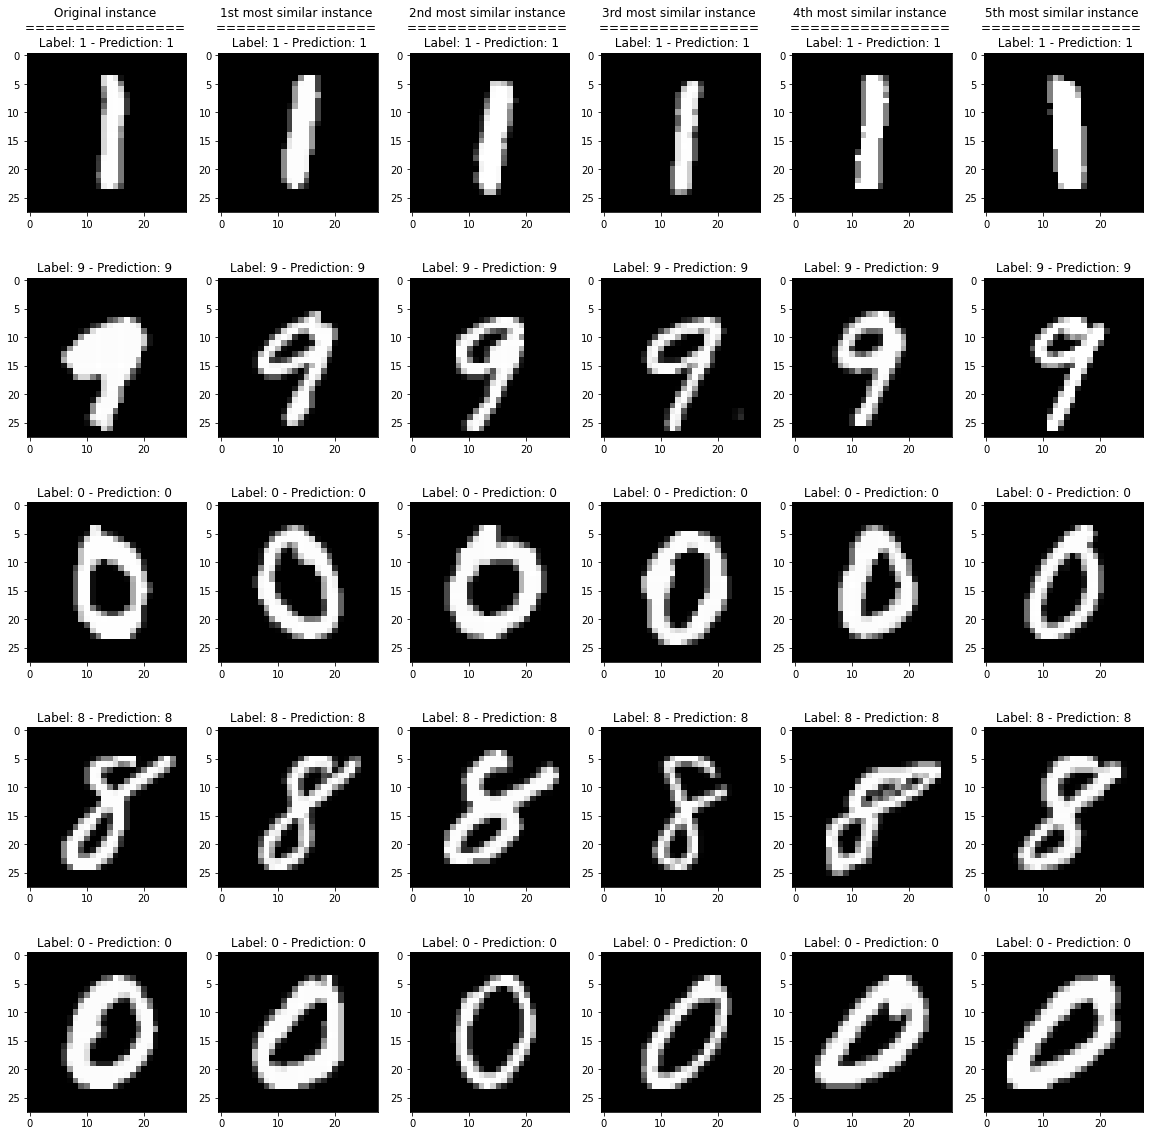

In [31]:
plot_similar(ds, expls)

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class and to same predicted class. 

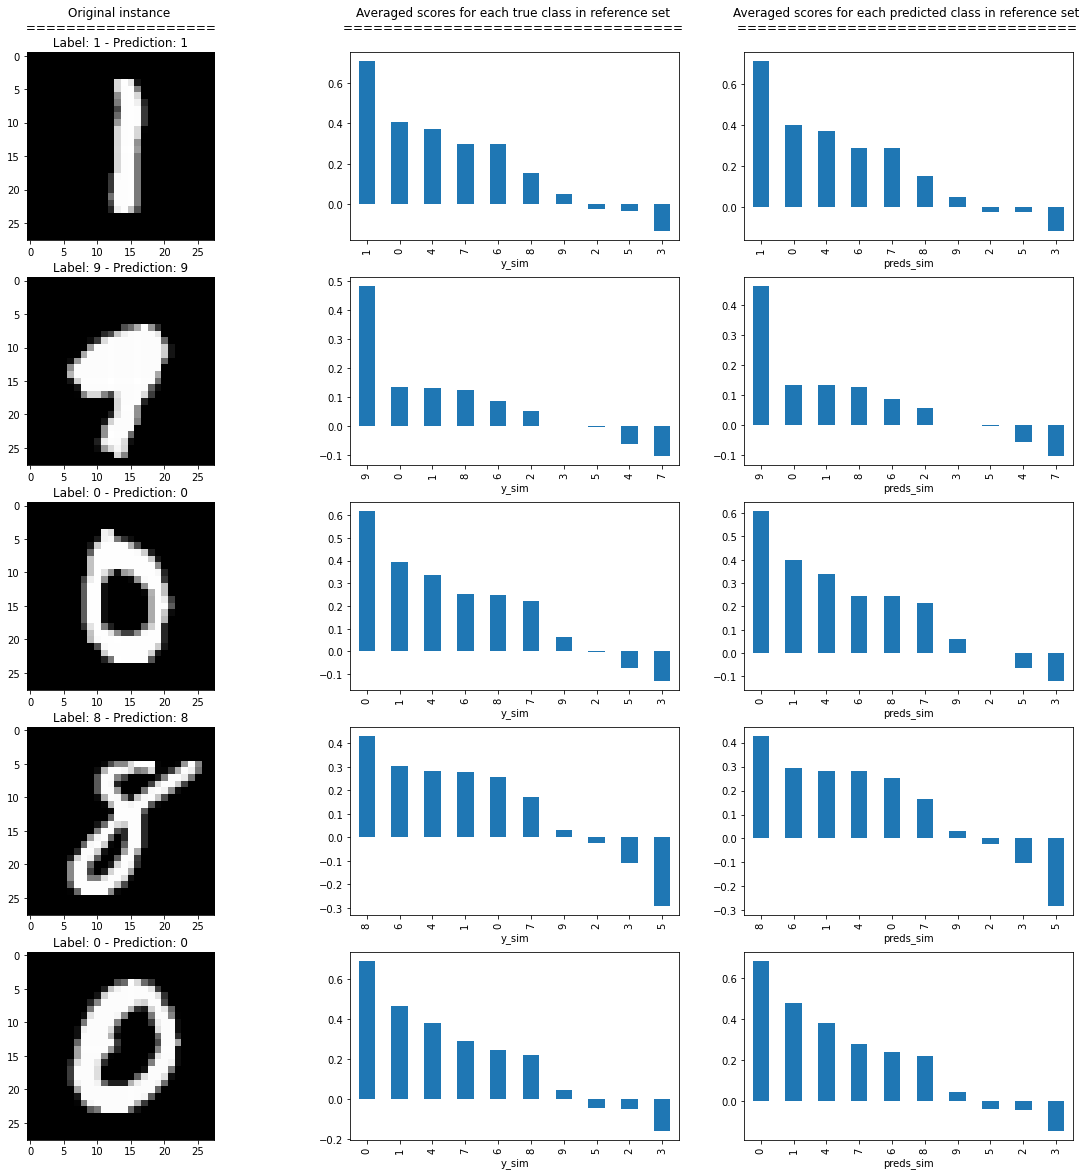

In [36]:
plot_distributions(ds, expls)